# Starbucks dataset

### Introduction

Starbucks datasets consist of portfolio, profile, and transcript datasets. The datasets represent offer portfolio, customer profile, and customer behavior on the Starbucks rewards mobile app.

Once every few days, Starbucks sends out an offer to customers on the mobile applications. An offer can be a BOGO (buy one get one free) or a discount or just an advertisement/information for a drink. Some customers might not receive any offers during certain weeks.

### Example

The company sends an offer to a customer via different channels depending on an offer. Then the customer received an offer. The offer has a duration time and a condition to complete. For instance, the company sends a discount buy 10 dollars get 5 off to a customer via website and email. Then the custom received the discount offer on Monday. The offer is valid for 7 day and has a condition to complete the offer. 

The customer needs to accumulate at least 20 dollars in purchases during the valid period to get an offer. If the customer accumulative spend meet 10 dollars and complete the offer in time, the customer completes the offer and receives a 5 dollars discount.

There is cautious information about the datasets; A customer might complete an offer without viewing the offer or received an offer but never open the offer during the available period.

# Objective: Predicts whether or not someone will respond to an offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Import The libraries

In [1]:
# Set a jupyter notebook coding container to fit the borders of a web browser.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Do not need to call plt.show() when ploting a graph
%matplotlib inline 
sns.set()

In [3]:
# GridSearch
from sklearn.model_selection import GridSearchCV

# Outliers remover
from sklearn.ensemble import IsolationForest

# Data Preparations
from sklearn.model_selection import train_test_split

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Main Model
import xgboost as xgb

# Models for justification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree

# Model comparison
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Load The Datasets

In [4]:
# Load json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Functions

In [5]:
def id_mapper(df, column_name, remove_col=False):
    """ 
    Map id with number
    
    Args:
    df: dataframe. The pandas dataframe.
    column_name: string. The column name.
    remove_col: bool. Remove the orginal column or not
    
    Returns:
    offerid_encoded: The removed outliner dataframe by using z score.
    coded_dict: The coded dictionary
    
    """
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in df[column_name]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    if remove_col:
        del df[column_name]
    return id_encoded, coded_dict

def z_outlier_filter(df):
    """ 
    Filter outliner by statistic z score.
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values in each column.
    
    Returns:
    filtered_df: The removed outliner dataframe by using z score.
    
    """
    data = df.copy()
    
    # Calculate z-scores
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    
    # Set NaN to 0
    abs_z_scores[np.isnan(abs_z_scores)]= 0

    # The columns that have z-score > 3 are dropped
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    filtered_df = data[filtered_entries]
    return filtered_df

def ML_outlier_filter(df):
    """ 
    Filter outlier by Isolation Forest
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values and not contain any missing values.
    
    Returns:
    anomaly_solved: The removed outlier dataframe by using machine learning (isolationForest).
    
    """
    data = df.copy()
    # Define IsolationForest
    clf = IsolationForest(max_samples=100, random_state = 42, contamination= 'auto')
    data['anomaly'] = clf.fit_predict(data)
    
    # Select normal datapoints
    anomaly_solved = data[data['anomaly'] == 1]
    anomaly_solved = anomaly_solved.drop('anomaly',axis=1)
    return anomaly_solved

# Data preparation

## 1. The portfolio cleaning process 

## Data exploration

In [6]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


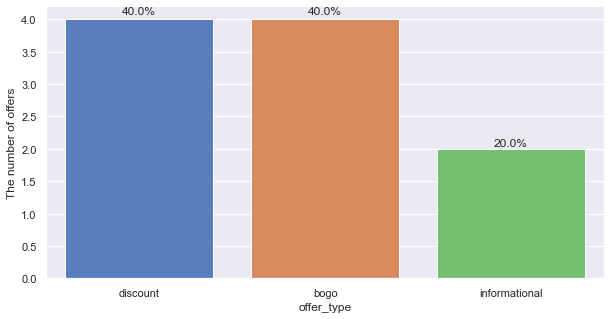

In [7]:
# Explore offer_type column
plt.figure(figsize=(10, 5))

ax = sns.countplot(x = 'offer_type', data = portfolio, palette="muted", order = portfolio['offer_type'].value_counts().index)
plt.ylabel('The number of offers')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(portfolio['offer_type'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

### 1.1 Find the columns that have mssing value

In [8]:
# Find the columns that have NaN value
portfolio.columns[portfolio.isna().mean() > 0]

Index([], dtype='object')

### 1.2 Dehash hash_id to readable id

In [9]:
# Dehash hash_id to readable id
encoded_offer_ids, offer_coded_dict = id_mapper(portfolio, 'id')
portfolio['offer_id'] = encoded_offer_ids

### 1.3 Create dummies for channels column

In [10]:
# Create the dummies for channels column
channel_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
cleaned_portfolio = pd.concat([portfolio, channel_dummies], axis=1)

In [11]:
cleaned_portfolio[['email','mobile','social','web','channels']].head()

,email,mobile,social,web,channels
0,1,1,1,0,"[email, mobile, social]"
1,1,1,1,1,"[web, email, mobile, social]"
2,1,1,0,1,"[web, email, mobile]"
3,1,1,0,1,"[web, email, mobile]"
4,1,0,0,1,"[web, email]"


### 1.4 Rename columns

In [12]:
# Rename column name to make it readable
cleaned_portfolio.rename({'id': 'hashed_offer_id'}, axis = 1, inplace = True)

In [14]:
# Cleaned portfolio
cleaned_portfolio.head()

,reward,channels,difficulty,duration,offer_type,hashed_offer_id,offer_id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,2,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1


## 2. The profile cleaning process 

## Data exploration

In [15]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


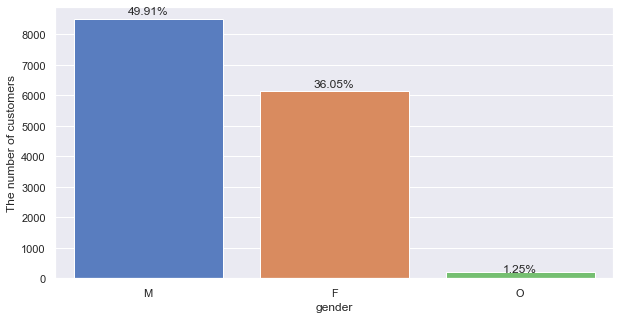

In [16]:
# Explore gender column
plt.figure(figsize=(10, 5))
ax = sns.countplot(x = 'gender', data = profile, palette="muted", order = profile['gender'].value_counts().index)
plt.ylabel('The number of customers')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(profile['gender'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

Text(0, 0.5, 'The number of customers')

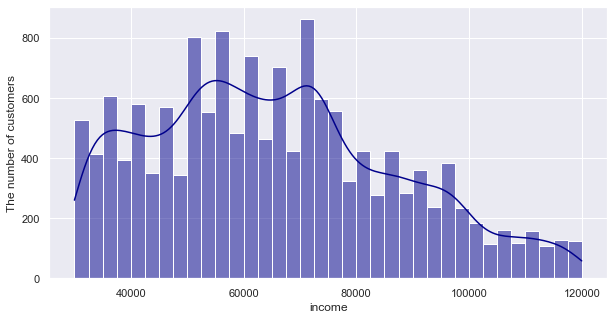

In [17]:
# Explore income column
plt.figure(figsize=(10, 5))
sns.histplot(profile['income'], color='darkblue', kde=True)
plt.ylabel('The number of customers')

In [18]:
# Min and Max of customer's income
profile['income'].min(), profile['income'].max()

(30000.0, 120000.0)

Text(0, 0.5, 'The number of customers')

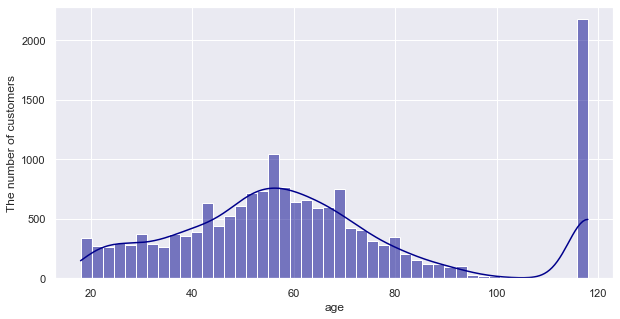

In [19]:
# Explore Age column
plt.figure(figsize=(10, 5))
sns.histplot(profile['age'], kde=True, color='darkblue')
plt.ylabel('The number of customers')

### 2.1 Find the columns that contain missing values

In [20]:
# Find the columns that have missing values (NaN)
profile.columns[profile.isna().mean() > 0]

Index(['gender', 'income'], dtype='object')

### 2.2 Investigate missing values

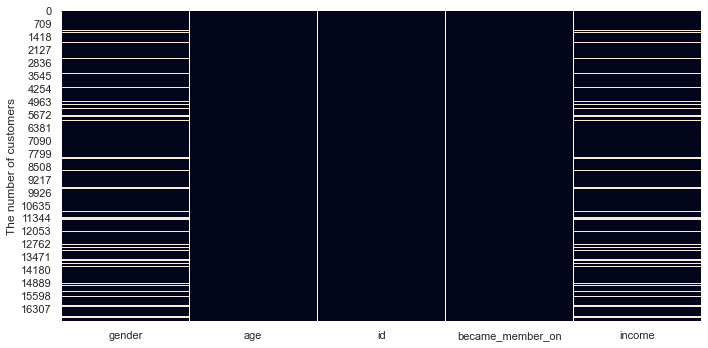

In [21]:
# Plot the missing values
plt.figure(figsize=(10, 5))
ax = sns.heatmap(profile.isnull(), cbar=False)
plt.ylabel('The number of customers')
for i in range(profile.isnull().shape[1]+1):
    ax.axvline(i, color='white', lw=1)
plt.tight_layout()

In [22]:
# Detected the abnormal relationship between income (NaN) and age values(118)
profile[(profile['age'] == 118) & (profile['income'].isna())].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


### 2.3 Drop missing values
Remove the missing value (NaN) because of abnormal relationship pattern (age=118, gender=None, income=NaN).

In [23]:
# Remove the NaN that come from the abnormal relationship
profile.dropna(subset=['income'], inplace = True)
# Reset index after drop NaN
profile.reset_index(drop=True, inplace=True)

### 2.4 Convert date string to date type

In [24]:
# Convert date string to date type
profile.loc[:,'became_member_on'] = pd.to_datetime(profile.loc[:,'became_member_on'], format='%Y%m%d', errors='coerce')

### 2.5 Dehash hash_id to readable id

In [25]:
# Map hash_id to readable id
encoded_customer_ids, customer_coded_dict = id_mapper(profile, 'id')
profile['customer_id'] = encoded_customer_ids

### 2.6 Rename columns

In [26]:
# Rename to make columns more meaningful
cleaned_profile = profile.rename({'id': 'hash_customer_id'}, axis = 1)

In [27]:
# Cleaned profile
cleaned_profile.head()

,gender,age,hash_customer_id,became_member_on,income,customer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,3
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,4
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,5


## Data exploration after dropped abnormal values

Text(0, 0.5, 'The number of customers')

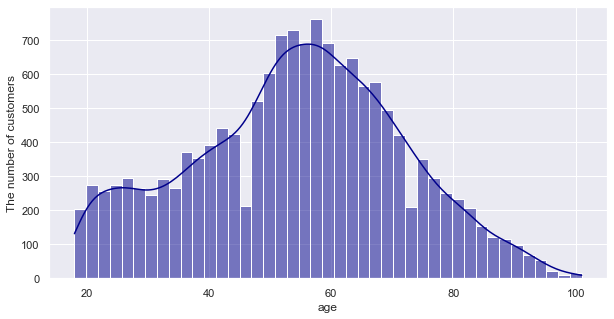

In [28]:
# Plot the customer age distribution after dropped the abnormal or outlier values 
plt.figure(figsize=(10, 5))
sns.histplot(cleaned_profile['age'], kde=True, color='darkblue')
plt.ylabel('The number of customers')

## 3. The transcript cleaning process

## Data exploration

In [29]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


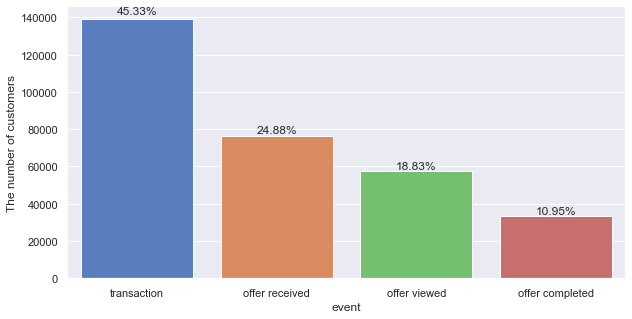

In [30]:
# Plot the ratio of value type in the event column
plt.figure(figsize=(10, 5))
ax = sns.countplot(x = 'event', data = transcript, palette="muted", order = transcript['event'].value_counts().index)
plt.ylabel('The number of customers')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(transcript['event'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

### 3.1 Explore the value column
Explore value column which contain json type in transcript dataframe

In [31]:
# Explore value column in transcript dataframe
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

### 3.2 Find the columns that contain missing values

In [32]:
# Find the columns that have missing values (NaN)
transcript.columns[transcript.isna().mean() > 0]

Index([], dtype='object')

### 3.3 Dehash customer id to readable id
Dehash the customer id first to reduce data cleaning time.

In [33]:
# Create customer_id column
transcript['customer_id'] = np.nan

# Dehash the person column
# Change hashed id to readable id
for idx, value in enumerate(transcript['person']):
    if value in customer_coded_dict:
        transcript.loc[idx,'customer_id'] = customer_coded_dict[value]

### 3.4 Extract variables from value dictionary column
Extract the hashed offer id, reward, and amount from dictionary value columns to new columns

In [34]:
# Extract the hashed offer id, reward, and amount from dictionary value columns to new columns below
# Declare the desired columns then fill with nan values
transcript['hashed_offer_id'] = np.nan
transcript['reward'] = np.nan
transcript['amount'] = np.nan

for i, value in enumerate(transcript['value']):
    if 'reward' in value:
        transcript.loc[i,'reward']  = value['reward']
    if 'offer id' in value:
        transcript.loc[i,'hashed_offer_id']  = value['offer id']    
    if 'offer_id' in value:
        transcript.loc[i,'hashed_offer_id']  = value['offer_id']
    elif 'amount' in value:
        transcript.loc[i,'amount']  = value['amount']

In [35]:
transcript.head()

,person,event,value,time,customer_id,hashed_offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,2.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,3.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### 3.5 Drop the customer ids that have missing values
The missing value occurs because this dataset contains abnormal customer id likewise the profile dataset. The missing value must be removed likewise profile dataset.

In [36]:
# Drop customer ids that that has missing values
transcript.dropna(subset=['customer_id'], axis=0, inplace=True)

# Reset index
transcript.reset_index(drop=True, inplace=True)

### 3.6 Dehash hashed offer id to readable id
Convert extracted hashed offer_id to readable offer_id

In [37]:
# Map extracted hashed offer_id to readable offer_id
transcript['offer_id'] = np.nan

# Customer_id
for idx, value in enumerate(transcript['hashed_offer_id']):
    if value in offer_coded_dict:
        transcript.loc[idx,'offer_id'] = offer_coded_dict[value]

### 3.7 Rename columns

In [38]:
# Rename
cleaned_transcript = transcript.rename({'person': 'hashed_customer_id', 'value': 'dict_value'}, axis = 1)

## 4. Build training dataset 
Build training dataset from three datasets from cleaned datasets above 

## Find the offer that customer responds.
- Offers are responded when customer both viewed and completed the offer.

### 4.1 Select non-transaction events

In [39]:
# Fetch the non-transaction events
offer_transcript = cleaned_transcript[cleaned_transcript['event'] != 'transaction'].drop('amount', axis=1)
# Reset index after drop the transaction event
offer_transcript.reset_index(drop=True, inplace=True)
offer_transcript.head()

,hashed_customer_id,event,dict_value,time,customer_id,hashed_offer_id,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,2.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,3.0,2906b810c7d4411798c6938adc9daaa5,NaN,10.0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,4.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,9.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,5.0,3f207df678b143eea3cee63160fa8bed,NaN,3.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,6.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0


### 4.2 Build dictionaries
- responsed_dict: The dictionary between customer_id and the list of responsed offer
- offer_dict: The dictionary between customer_id and the list of viewed offer

In [40]:
# Sort the offers by customer_id and time, sequentially
sorted_offers = offer_transcript.sort_values(by=['customer_id','time'])

# Create unique customer id to iterate a for loop
unique_custid = sorted_offers['customer_id'].astype(int).unique()

# The dictionaries that match between the customer id and the list of offer ids
responsed_dict = dict() 
offer_dict = dict() 

for custid in unique_custid:
    received_offer = []
    track_viewed_offer = []
    responsed_offer = []
    
    # Select dataframe of specific customer id
    df_offers = offer_transcript[offer_transcript['customer_id'] == custid]
    df_offers.reset_index(drop=True,inplace=True)
    
    for idx, event in enumerate(df_offers['event']):
        if event == 'offer received':
            # Store the recieved offer
            received_offer.append(df_offers.loc[idx, 'offer_id'])
        elif event == 'offer viewed':
            # if offer is not in track_viewed_offer add it
            if not df_offers.loc[idx, 'offer_id'] in track_viewed_offer:
                track_viewed_offer.append(df_offers.loc[idx, 'offer_id'])
        elif event == 'offer completed':
            # Offer are responded when customer both view the offer and then completed offer
            if df_offers.loc[idx, 'offer_id'] in track_viewed_offer:
                responsed_offer.append(df_offers.loc[idx, 'offer_id'])
                track_viewed_offer.remove(df_offers.loc[idx, 'offer_id'])
                
    # Create dictionaries for current customer_id
    responsed_dict[custid] = responsed_offer # the offers that are responsed by current customer id
    offer_dict[custid] = received_offer # the offers that give to current customer id 

### 4.3 Create a training dataset by using the dictionaries above

In [41]:
# Check the responsed_dict
dict(list(responsed_dict.items())[:5])

{1: [], 2: [4.0, 1.0], 3: [4.0, 7.0], 4: [9.0, 10.0, 4.0, 9.0, 7.0], 5: [7.0]}

In [42]:
# Check the offer_dict
dict(list(offer_dict.items())[:5])

{1: [4.0, 3.0],
 2: [4.0, 8.0, 1.0, 9.0],
 3: [10.0, 3.0, 4.0, 7.0],
 4: [9.0, 4.0, 10.0, 4.0, 9.0, 7.0],
 5: [3.0, 6.0, 7.0]}

In [43]:
# Create response (target) column by dictionaries above then merge datasets
cleaned_profile['response'] = np.nan

#The number of offer
num=0

# For each customer id 
for custid in offer_dict:
    for offer_id in offer_dict[custid]:
        # Select profile dataset that has customer id ...
        df_profile = cleaned_profile[cleaned_profile['customer_id'] == custid].reset_index(drop=True)
        df_portfolio = cleaned_portfolio[cleaned_portfolio['offer_id'] == offer_id].reset_index(drop=True)
        if num==0:
            features = pd.concat([df_profile,df_portfolio], axis=1)
        else:
            new_features = pd.concat([df_profile,df_portfolio], axis=1)
            features = pd.concat([features,new_features], axis=0).reset_index(drop=True)
        # Assign response or not response to column
        if offer_id in responsed_dict[custid]:
            features.loc[num, 'response'] = 1
        else:
            features.loc[num, 'response'] = 0
        num+=1
features.head()

,gender,age,hash_customer_id,became_member_on,income,customer_id,response,reward,channels,difficulty,duration,offer_type,hashed_offer_id,offer_id,email,mobile,social,web
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0.0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,1,1,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0.0,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3,1,1,0,1
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2,1.0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,1,1,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2,0.0,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,8,1,1,1,0
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2,1.0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1,0


## 5. Clean training dataset

### 5.1 Drop unused columns
- channels: JSON format doesn't provide useful information.
- hashed_offer_id: Duplicates with offer_id hashed value.
- id columns: Not provide a meaningful analysis.
- became_member_on: Doesn't use to analysis

In [44]:
# Select columns according to the list
cols = ['gender','age','income','reward','difficulty',
        'duration','offer_type','email','mobile','social','web','response']
df = features.loc[:, cols]
df.head()

,gender,age,income,reward,difficulty,duration,offer_type,email,mobile,social,web,response
0,F,55,112000.0,5,5,7,bogo,1,1,0,1,0.0
1,F,55,112000.0,0,0,4,informational,1,1,0,1,0.0
2,F,75,100000.0,5,5,7,bogo,1,1,0,1,1.0
3,F,75,100000.0,0,0,3,informational,1,1,1,0,0.0
4,F,75,100000.0,10,10,7,bogo,1,1,1,0,1.0


### 5.2 Find the columns that contain missing values

In [45]:
# Find the columns that have missing value value (NaN)
df.columns[df.isna().mean() > 0]

Index([], dtype='object')

## Explore data distributions (before and after reomve outliers)

### Age

<AxesSubplot:xlabel='age', ylabel='Count'>

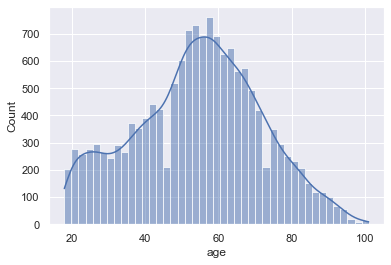

In [46]:
# Before create training dataset
sns.histplot(cleaned_profile['age'], kde=True)

<AxesSubplot:xlabel='age', ylabel='Count'>

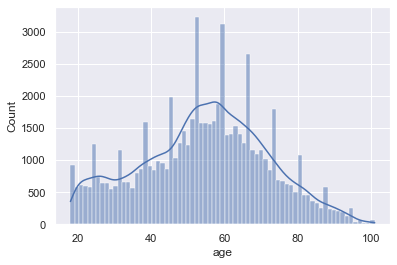

In [47]:
# After created training dataset
sns.histplot(df['age'], kde=True)

### Income

<AxesSubplot:xlabel='income', ylabel='Count'>

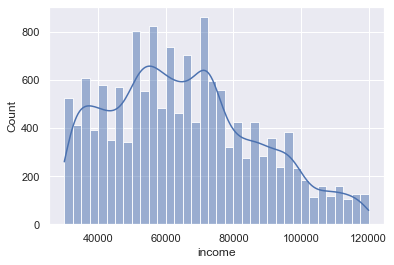

In [48]:
# Before create training dataset
sns.histplot(cleaned_profile['income'], kde=True)

<AxesSubplot:xlabel='income', ylabel='Count'>

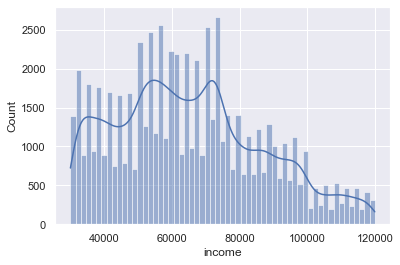

In [49]:
# After created training dataset
sns.histplot(df['income'], kde=True)

### Gender

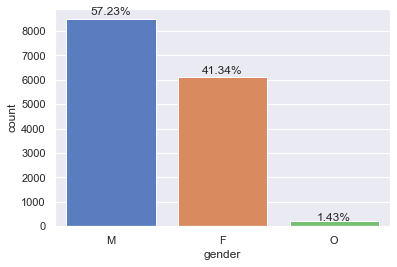

In [50]:
# Before create training dataset
ax = sns.countplot(x = 'gender', data = profile, palette="muted", order = profile['gender'].value_counts().index)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(profile['gender'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center')

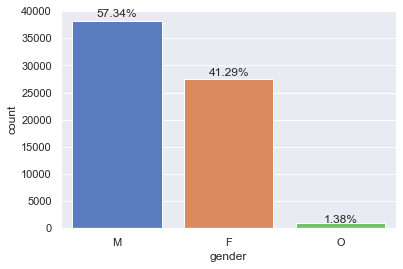

In [51]:
# After created training dataset
ax = sns.countplot(x = 'gender', data = df, palette="muted", order = df['gender'].value_counts().index)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(df['gender'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center')

### Offer_type or Event

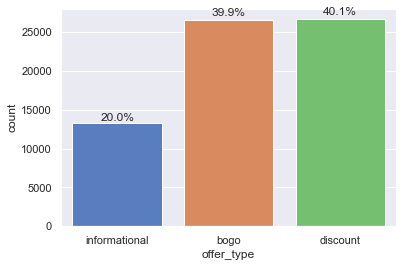

In [52]:
# Plot offer_type ratio
ax = sns.countplot(x = 'offer_type', data = df, palette="muted", order = df['offer_type'].value_counts(ascending=True).index)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(df['offer_type'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

### 5.3 Remove outliers
An outlier is a crucial problem that makes our model inaccurate and inefficient. we should handle it before performing any actor that relates to machine learning or modeling.

In [53]:
# Separate columns to remove outlier and not remove outlier.
remove_outlier = df[['age','income']]
not_remove_outlier = df.drop(['age','income'],axis=1)

### 5.3.1 The statistic z-score
- Filter outliner by statistic z score.

In [54]:
# Remove outliers by statistic z-score method
z_anomaly_solved = z_outlier_filter(remove_outlier)

### 5.3.2 Isolation Forest
- Isolation Forest is an outlier detection technique that identifies anomalies instead of normal observations
- The Isolation Forest isolate observations into abnormal vs normal observations by the following step:
<br><img src="images/Isolation_forest_pic.png" align="left"/>

- At each node in the decision tree, randomly select a feature then selecting a splitting value between maximum and minimum values of the selected feature/column to split the dataset into two.
- After that, keep doing the above step until all observations are isolated from each other.
- The anomalies are detected by finding the observation that is isolated faster or easier than other observations because the anomalies are normally far from normal observations.

In [55]:
# Remove outliers by manchine learning method
anomaly_solved = ML_outlier_filter(z_anomaly_solved)

### Merge data after remove outlier

In [56]:
# Combine numeric features and catergorical features
not_remove_outlier_df = pd.DataFrame(not_remove_outlier,index = anomaly_solved.index)
removed_outlier = pd.concat([not_remove_outlier_df, anomaly_solved], axis=1)

# Reset index after dropped the rows that contain missing values
removed_outlier.reset_index(drop=True, inplace=True)
removed_outlier.shape

(38144, 12)

In [57]:
# Finished cleaning dataset
removed_outlier.head()

,gender,reward,difficulty,duration,offer_type,email,mobile,social,web,response,age,income
0,M,2,10,7,discount,1,1,0,1,0.0,68,70000.0
1,M,0,0,4,informational,1,1,0,1,0.0,68,70000.0
2,M,5,5,7,bogo,1,1,0,1,1.0,68,70000.0
3,M,2,10,10,discount,1,1,1,1,1.0,68,70000.0
4,M,5,5,5,bogo,1,1,1,1,1.0,65,53000.0


### 5.4 Apply One-hot encoding on categorical columns

In [58]:
# Drop a target column
df_features = removed_outlier.drop('response', axis=1)

# Apply One-hot encoding on categorical columns
cleaned_df = pd.get_dummies(df_features, columns=['gender','offer_type'])

In [59]:
cleaned_df.head()

,reward,difficulty,duration,email,mobile,social,web,age,income,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,2,10,7,1,1,0,1,68,70000.0,0,1,0,0,1,0
1,0,0,4,1,1,0,1,68,70000.0,0,1,0,0,0,1
2,5,5,7,1,1,0,1,68,70000.0,0,1,0,1,0,0
3,2,10,10,1,1,1,1,68,70000.0,0,1,0,0,1,0
4,5,5,5,1,1,1,1,65,53000.0,0,1,0,1,0,0


## Compare dataset before and after removed outliner 

### Age

<AxesSubplot:xlabel='age', ylabel='Count'>

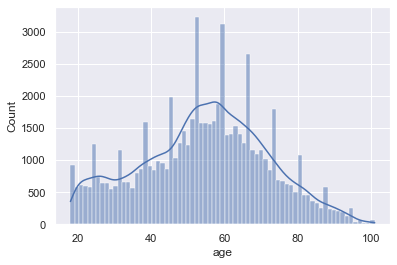

In [60]:
sns.histplot(df['age'], kde=True)

<AxesSubplot:xlabel='age', ylabel='Count'>

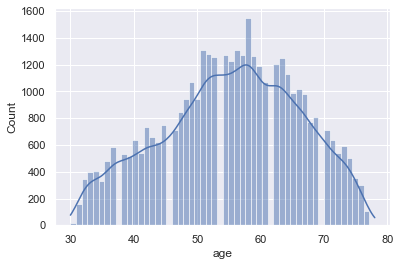

In [61]:
sns.histplot(removed_outlier['age'], kde=True)

### Income

<AxesSubplot:xlabel='income', ylabel='Count'>

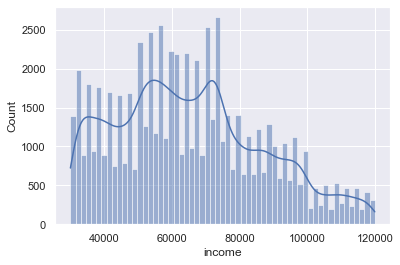

In [62]:
# Before
sns.histplot(df['income'], kde=True)

<AxesSubplot:xlabel='income', ylabel='Count'>

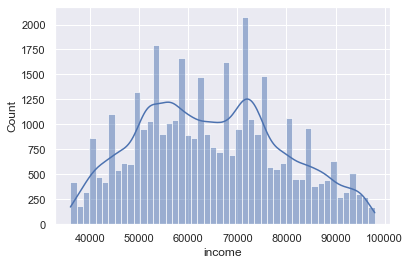

In [63]:
# After
sns.histplot(removed_outlier['income'], kde=True)

# Build a Model

## 1. Declare X (features) and y (target)

In [64]:
# Declare a target
y = removed_outlier['response'].copy().astype(int)

# Declare features
X = cleaned_df.copy()
X.head()

,reward,difficulty,duration,email,mobile,social,web,age,income,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,2,10,7,1,1,0,1,68,70000.0,0,1,0,0,1,0
1,0,0,4,1,1,0,1,68,70000.0,0,1,0,0,0,1
2,5,5,7,1,1,0,1,68,70000.0,0,1,0,1,0,0
3,2,10,10,1,1,1,1,68,70000.0,0,1,0,0,1,0
4,5,5,5,1,1,1,1,65,53000.0,0,1,0,1,0,0


## 2. Split the data to training and testing data

In [65]:
# Split the data to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [66]:
# Check the target ratio 
sum(y_train)/len(y_train)

0.4106194071588367

In [67]:
X_train.head()

,reward,difficulty,duration,email,mobile,social,web,age,income,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
26624,5,5,5,1,1,1,1,67,43000.0,0,1,0,1,0,0
5304,5,5,7,1,1,0,1,44,74000.0,1,0,0,1,0,0
24815,0,0,3,1,1,1,0,65,70000.0,0,1,0,0,0,1
24412,5,5,5,1,1,1,1,59,55000.0,1,0,0,1,0,0
290,10,10,7,1,1,1,0,55,94000.0,1,0,0,1,0,0


## 3 Build and train XGBoost Classifier model for predict the response

### 3.1 The model without refinement

In [68]:
clf = xgb.XGBClassifier(objective='binary:logistic', seed=42, eval_metric='auc')
clf.fit(X_train,
        y_train,
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='auc',
        eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.79344
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.79482
[2]	validation_0-auc:0.79596
[3]	validation_0-auc:0.79655
[4]	validation_0-auc:0.79767
[5]	validation_0-auc:0.79792
[6]	validation_0-auc:0.79825
[7]	validation_0-auc:0.79866
[8]	validation_0-auc:0.79862
[9]	validation_0-auc:0.79878
[10]	validation_0-auc:0.79906
[11]	validation_0-auc:0.79906
[12]	validation_0-auc:0.79924
[13]	validation_0-auc:0.79930
[14]	validation_0-auc:0.79919
[15]	validation_0-auc:0.79912
[16]	validation_0-auc:0.79898
[17]	validation_0-auc:0.79936
[18]	validation_0-auc:0.79946
[19]	validation_0-auc:0.79937
[20]	validation_0-auc:0.79970
[21]	validation_0-auc:0.79968
[22]	validation_0-auc:0.79970
[23]	validation_0-auc:0.79988
[24]	validation_0-auc:0.80002
[25]	validation_0-auc:0.80003
[26]	validation_0-auc:0.80024
[27]	validation_0-auc:0.80004
[28]	validation_0-auc:0.80007
[29]	validation_0-auc:0.80017
[30]	validation_0-auc:0.80053
[31]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

## Evaluation the initial model

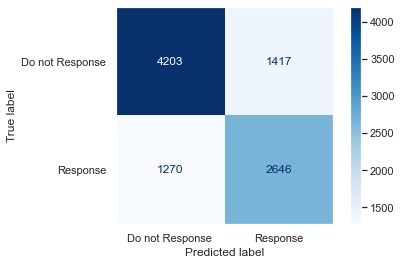

In [69]:
# Plot confusion matrix 
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      cmap = 'Blues',
                      values_format = 'd',
                      display_labels = ['Do not Response','Response'])
# Hide background grid
plt.grid(b=None)

In [70]:
# True Positive Rate
(4203/(1417+4203))*100

74.7864768683274

In [71]:
# False Positive Rate
(2616/(1270+2616))*100

67.31857951621204

### 3.2 the model with refining 

In [72]:
# GridSearch to find optimal hyperparameters
# ROUND 1
param_grid = {
    'max_depth': [10, 11], # Tree depth
    'learning_rate': [0.2, 0.3], # The value that use to prune the tree
    'gamma': [0, 1], # Max tree depth
    'reg_lambda': [0.5, 1], # L2 regularization
    'min_child_weight':[0, 1] # Cover 
}

# Optimizie xgboosthyperparameters
optimized_xgb = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic', seed=42),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose=2,
    n_jobs = -1)

optimized_xgb.fit(X_train,
                y_train,
                verbose=True, # Do not print the process
                early_stopping_rounds=10, # stop a validation if the eval_metric score doesn’t improve for n rounds
                eval_metric='auc', # an evaluation metric (Benchmark)
                eval_set=[(X_test, y_test)])
print(optimized_xgb.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.8s


[0]	validation_0-auc:0.79083
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.79408
[2]	validation_0-auc:0.79637
[3]	validation_0-auc:0.79783
[4]	validation_0-auc:0.79935
[5]	validation_0-auc:0.80066
[6]	validation_0-auc:0.80182
[7]	validation_0-auc:0.80257
[8]	validation_0-auc:0.80322


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.3min finished


[9]	validation_0-auc:0.80390
[10]	validation_0-auc:0.80466
[11]	validation_0-auc:0.80525
[12]	validation_0-auc:0.80649
[13]	validation_0-auc:0.80720
[14]	validation_0-auc:0.80726
[15]	validation_0-auc:0.80806
[16]	validation_0-auc:0.80884
[17]	validation_0-auc:0.80917
[18]	validation_0-auc:0.80943
[19]	validation_0-auc:0.81024
[20]	validation_0-auc:0.81056
[21]	validation_0-auc:0.81084
[22]	validation_0-auc:0.81114
[23]	validation_0-auc:0.81166
[24]	validation_0-auc:0.81208
[25]	validation_0-auc:0.81211
[26]	validation_0-auc:0.81205
[27]	validation_0-auc:0.81240
[28]	validation_0-auc:0.81263
[29]	validation_0-auc:0.81283
[30]	validation_0-auc:0.81278
[31]	validation_0-auc:0.81278
[32]	validation_0-auc:0.81259
[33]	validation_0-auc:0.81277
[34]	validation_0-auc:0.81290
[35]	validation_0-auc:0.81331
[36]	validation_0-auc:0.81388
[37]	validation_0-auc:0.81400
[38]	validation_0-auc:0.81405
[39]	validation_0-auc:0.81404
[40]	validation_0-auc:0.81419
[41]	validation_0-auc:0.81433
[42]	valida

## Evaluate the optimal model

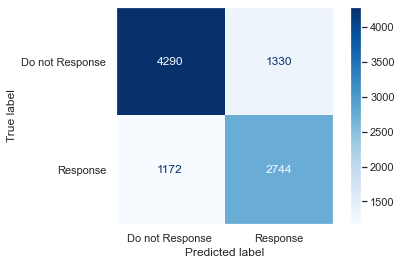

In [73]:
# Plot confusion matrix 
plot_confusion_matrix(optimized_xgb,
                      X_test,
                      y_test,
                      cmap = 'Blues',
                      values_format = 'd',
                      display_labels = ['Do not Response','Response'])
# Hide background grid
plt.grid(b=None)

In [74]:
# True Positive Rate
(4290/(1330+4290))*100

76.33451957295374

In [75]:
# True Negative Rate
(2744/(1172+2744))*100

70.07150153217569

## Comparison of ROC betwen initial model and optimized model

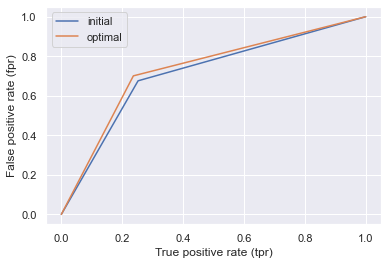

In [76]:
# Plot initial and optimal models ROC graph
plt.xlabel("True positive rate (tpr)")
plt.ylabel("False positive rate (fpr)")

# Initial model
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))
roc_auc_score(y_test, clf.predict(X_test))
plt.plot(fpr, tpr)

# Optimal model
fpr, tpr, thresholds = roc_curve(y_test, optimized_xgb.predict(X_test))
roc_auc_score(y_test, optimized_xgb.predict(X_test))
plt.plot(fpr, tpr)

plt.gca().legend(('initial','optimal'))

In [77]:
print ("Initial model AUC score:",round(roc_auc_score(y_test, clf.predict(X_test)),2)*100)
print ("Optimal model AUC score:",round(roc_auc_score(y_test, optimized_xgb.predict(X_test)),2)*100)

Initial model AUC score: 71.0
Optimal model AUC score: 73.0


# The model robustness

## 1. The ratio of target
The target ratio should be reasonable to prevent an overfitting problem.

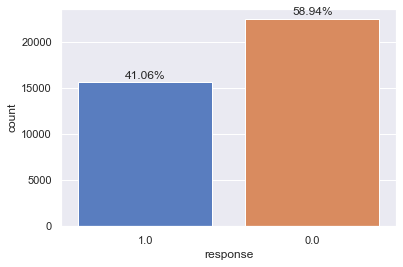

In [78]:
# Plot respond (target) ratio
 ax = sns.countplot(x = 'response', data = removed_outlier, palette="muted", order = removed_outlier['response'].value_counts(ascending=True).index)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(removed_outlier['response'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

## 2. The difference between the AUC value in the training and the validation data set
Make sure that the testing AUC value are not higher that testing value to prevent an overfitting problem.

## Training dataset

In [79]:
# Testing dataset
training_pred = optimized_xgb.predict(X_train)

# ROC
training_fpr, training_tpr, training_thresholds = roc_curve(y_train, training_pred)

# AUC
roc_auc_score(y_train, training_pred)

0.8796895711118597

## Testing dataset

In [80]:
# Training dataset
testing_pred = optimized_xgb.predict(X_test)

# ROC
testing_fpr, testing_tpr, testing_thresholds = roc_curve(y_test, testing_pred)

# AUC
roc_auc_score(y_test, testing_pred)

0.7320301055256472

## Comparison of ROC for training and testing dataset

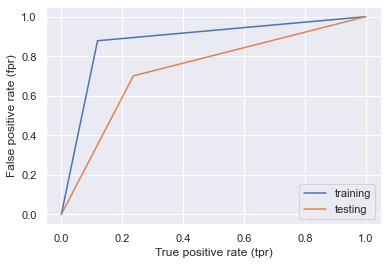

In [81]:
plt.xlabel("True positive rate (tpr)")
plt.ylabel("False positive rate (fpr)")

plt.plot(training_fpr, training_tpr)
plt.plot(testing_fpr, testing_tpr)

plt.gca().legend(('training','testing'))

In [82]:
# Testing dataset
training_pred = optimized_xgb.predict(X_train)

# ROC
training_fpr, training_tpr, training_thresholds = roc_curve(y_train, training_pred)

# AUC
roc_auc_score(y_train, training_pred)

0.8796895711118597

# Justification

## Comparison of classifier models

### Build candidatee models

In [83]:
# Find Accuarcy for each classifier model
# Logistic Classifier
logistic_clf = LogisticRegression(n_jobs=-1, random_state=42).fit(X_train, y_train)
logistic_acc = (logistic_clf.predict(X_test) == y_test).mean()*100

# NaiveBayes Classifier
gnb = GaussianNB().fit(X_train, y_train)
gnb_acc = (gnb.predict(X_test) == y_test).mean()*100

# KNN Classifier
KNN_neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
KNN_acc = (KNN_neigh.predict(X_test) == y_test).mean()*100

# Support Vector Machine
# Longtime to train
svc = SVC(gamma='auto').fit(X_train, y_train)
svc_acc = (svc.predict(X_test) == y_test).mean()*100

# Decision Tree Classifier
decision_tree_clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
decision_tree_acc = (logistic_clf.predict(X_test) == y_test).mean()*100

In [84]:
# Define randomforest hyperparameters
# Create the grid parameters
param_grid = {'n_estimators': [150, 200], # Number of trees in random forest
                  'max_depth': [11, 13], # Maximum number of levels in tree
                  'min_samples_split': [7,9,11], # Minimum number of samples required to split a node
                  'min_samples_leaf': [1,2], # Minimum number of samples required at each leaf node
                  'bootstrap': [True, False], # True: Bootstrap samples are used when building trees False: The whole dataset is used to build each tree
                  'random_state': [42]} # Method of selecting samples for training each tree
    
 # Perform the gridsearch and cross-validation to search for best hyperparameters
optimized_rf = GridSearchCV(estimator = RandomForestClassifier(), param_grid=param_grid, cv = 5, verbose=2, n_jobs = -1)

# Fit data to the opimize rf model
optimized_rf.fit(X_train, y_train)

# Random Forest Classifier Accuarcy
rf_acc = (optimized_rf.predict(X_test) == y_test).mean()*100

print(optimized_rf.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.2min finished


{'bootstrap': True, 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 150, 'random_state': 42}


In [85]:
xgb_acc = (optimized_xgb.predict(X_test) == y_test).mean()*100

## ROC graph

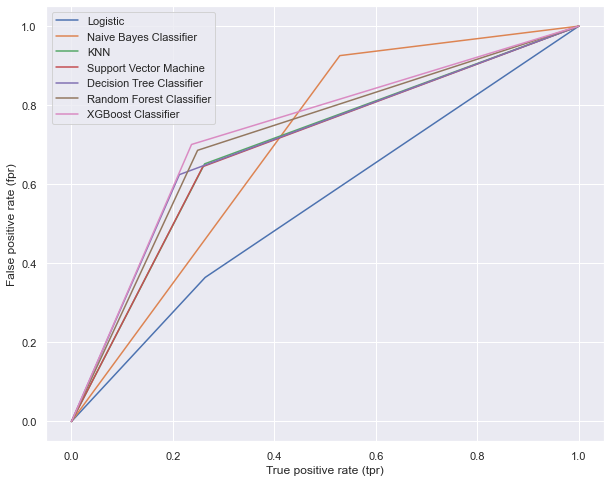

In [86]:
# Plot an ROC graph for each model
plt.figure(figsize=(10, 8))

plt.xlabel("True positive rate (tpr)")
plt.ylabel("False positive rate (fpr)")
 
# Logistic
fpr, tpr, thresholds = roc_curve(y_test, logistic_clf.predict(X_test))
logistic_auc = roc_auc_score(y_test, logistic_clf.predict(X_test))
plt.plot(fpr, tpr)
# Naive Bayes Classifier
fpr, tpr, thresholds = roc_curve(y_test, gnb.predict(X_test))
gnb_auc = roc_auc_score(y_test, gnb.predict(X_test))
plt.plot(fpr, tpr)
# KNN
fpr, tpr, thresholds = roc_curve(y_test, KNN_neigh.predict(X_test))
KNN_auc = roc_auc_score(y_test, KNN_neigh.predict(X_test))
plt.plot(fpr, tpr)
# Support Vector Machine
fpr, tpr, thresholds = roc_curve(y_test, svc.predict(X_test))
svc_auc = roc_auc_score(y_test, svc.predict(X_test))
plt.plot(fpr, tpr)
# Decision Tree Classifier
fpr, tpr, thresholds = roc_curve(y_test, decision_tree_clf.predict(X_test))
decision_tree_auc = roc_auc_score(y_test, decision_tree_clf.predict(X_test))
plt.plot(fpr, tpr)
# Random Forest Classifier
fpr, tpr, thresholds = roc_curve(y_test, optimized_rf.predict(X_test))
rf_auc = roc_auc_score(y_test, optimized_rf.predict(X_test))
plt.plot(fpr, tpr)
# XGBoost Classifier
fpr, tpr, thresholds = roc_curve(y_test, optimized_xgb.predict(X_test))
xgb_auc = roc_auc_score(y_test, optimized_xgb.predict(X_test))
plt.plot(fpr, tpr)

plt.gca().legend(('Logistic','Naive Bayes Classifier','KNN','Support Vector Machine',
                  'Decision Tree Classifier','Random Forest Classifier','XGBoost Classifier'))

## Comparison table

### AUC score

In [87]:
# Comparison of models
# Create AUC score for each candidate model
AUC_models = pd.DataFrame({
    'Model':['Logistic','Naive Bayes Classifier','KNN','Support Vector Machine','Decision Tree Classifier','Random Forest Classifier','XGBoost Classifier'],
    'AUC score':[logistic_auc,gnb_auc,KNN_auc,svc_auc,decision_tree_auc,rf_auc,xgb_auc]
})
AUC_models['AUC score'] = AUC_models['AUC score'].round(2)
AUC_models.sort_values(by='AUC score', ascending=False)

,Model,AUC score
6,XGBoost Classifier,0.73
5,Random Forest Classifier,0.72
4,Decision Tree Classifier,0.71
1,Naive Bayes Classifier,0.70
2,KNN,0.69
3,Support Vector Machine,0.69
0,Logistic,0.55


### Model Accuracy

In [88]:
# Comparison of models
# Create Accuracy for each candidate model
comp_models = pd.DataFrame({
    'Model':['Logistic','Naive Bayes Classifier','KNN','Support Vector Machine','Decision Tree Classifier','Random Forest Classifier','XGBoost Classifier'],
    'Accuracy':[logistic_acc,gnb_acc,KNN_acc,svc_acc,decision_tree_acc,rf_acc,xgb_acc]
})
comp_models['Accuracy'] = comp_models['Accuracy'].round(2)
comp_models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
6,XGBoost Classifier,73.76
5,Random Forest Classifier,72.45
2,KNN,70.23
3,Support Vector Machine,70.14
1,Naive Bayes Classifier,65.76
0,Logistic,58.37
4,Decision Tree Classifier,58.37


## Comparison of optimal XGBoost and Optimal Random Forest models

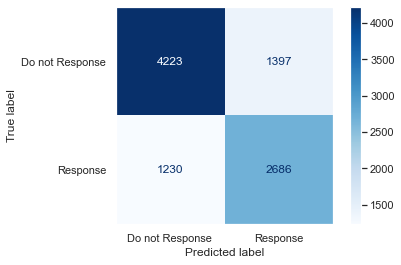

In [89]:
# Plot confusion matrix 
plot_confusion_matrix(optimized_rf,
                      X_test,
                      y_test,
                      cmap = 'Blues',
                      values_format = 'd',
                      display_labels = ['Do not Response','Response'])
# Hide background grid
plt.grid(b=None)

In [90]:
# True posivite rate
round(4223/(4223+1397)*100,2)

75.14

In [91]:
# True negative rate
round(2686/(1230+2686)*100,2)

68.59

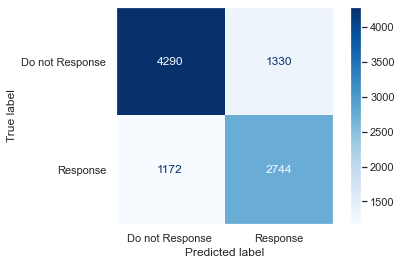

In [92]:
# Plot confusion matrix 
plot_confusion_matrix(optimized_xgb,
                      X_test,
                      y_test,
                      cmap = 'Blues',
                      values_format = 'd',
                      display_labels = ['Do not Response','Response'])
# Hide background grid
plt.grid(b=None)

In [93]:
# True posivite rate
round(4290/(4290+1330)*100,2)

76.33

In [94]:
# True negative rate
round(2744/(1172+2744)*100,2)

70.07

## Prediction example

In [95]:
X_train[:1]

,reward,difficulty,duration,email,mobile,social,web,age,income,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
26624,5,5,5,1,1,1,1,67,43000.0,0,1,0,1,0,0


In [96]:
optimized_xgb.predict(X_train[:1])

array([1])